In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import string

from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import confusion_matrix,roc_auc_score,log_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import xgboost as xgb 
seed = 4353

C:\Users\frank\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import sys
sys.executable

'C:\\Users\\frank\\Anaconda3\\python.exe'

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
print('Number of rows and columns in data set',train.shape)
train.head()

Number of rows and columns in data set (19579, 3)


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
train['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

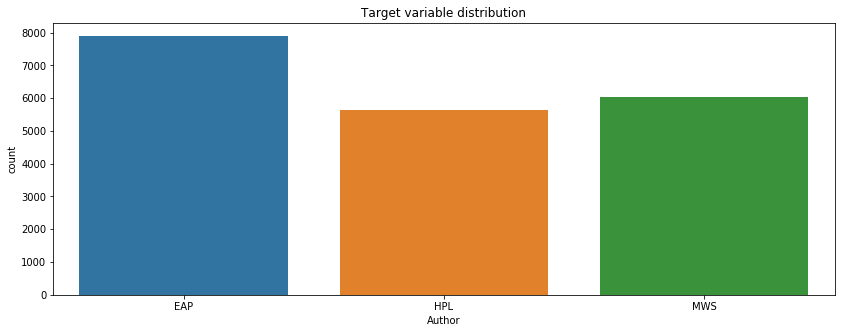

In [6]:
plt.figure(figsize=(14,5))
sns.countplot(train['author'],)
plt.xlabel('Author')
plt.title('Target variable distribution')
plt.show()

In [7]:
review = re.sub('[^A-Za-z0-9]'," ",train['text'][0]) 

In [8]:
review = word_tokenize(train['text'][0]) 
print('Word Tokenize:\n',review)

review = [word for word in str(train['text'][0]).lower().split() if  word not in set(stopwords.words('english'))]
print('\nRemoval of Stopwords:\n',review)

review = [word for word in str(train['text'][0]).lower().split() if  word in set(stopwords.words('english'))]
print('\nStopwords in the sentence:\n',review)

ps = PorterStemmer()
review = [ps.stem(word) for word in str(train['text'][0]).lower().split()]
print('\nStemming of word:\n',review)

Word Tokenize:
 ['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']

Removal of Stopwords:
 ['process,', 'however,', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon;', 'might', 'make', 'circuit,', 'return', 'point', 'whence', 'set', 'out,', 'without', 'aware', 'fact;', 'perfectly', 'uniform', 'seemed', 'wall.']

Stopwords in the sentence:
 ['this', 'me', 'no', 'of', 'the', 'of', 'my', 'as', 'i', 'its', 'and', 'to', 'the', 'i', 'being', 'of', 'the', 'so', 'the']

Stemming of word:
 ['thi', 'process,', 'however,', 'afford', 'me', 'no', 'mean', 'of', 'ascertain', 'the', 'dimens', 'of', 'my', 'dungeon;', 'as', 'i', 'might', 'make', 'it', 'circuit,', 'a

In [9]:
def clean_text(df):
    ps = PorterStemmer()
    corpus = []
    for i in range(0, df.shape[0]):        
        review = re.sub('[^A-Za-z0-9]'," ",df['text'][i])
        review = word_tokenize(review)        
        review = [word for word in review if word.lower() not in set(stopwords.words('english'))]
        review = [ps.stem(word) for word in review]
        review = ' '.join(review)
        corpus.append(review)
    
    return corpus

In [10]:
corp_train = clean_text(train)
corp_test = clean_text(test)
train['clean_text'] = corp_train
test['clean_text'] = corp_test
del corp_train,corp_test

In [11]:
def text_len(df):
    #i = ['text']
    df['num_words'] = df['text'].apply(lambda x: len(str(x).split()))
    df['num_uniq_words'] = df['text'].apply(lambda x: len(set(str(x).split())))
    df['num_chars'] = df['text'].apply(lambda x: len(str(x)))
    df['num_stopwords'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() 
                                                          if w in set(stopwords.words('english'))]))
    df['num_punctuations'] = df['text'].apply(lambda x: len([w for w in str(x) if w in string.punctuation]))
    df['num_words_upper'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    df['num_words_title'] = df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df['mean_word_len'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

text_len(train)
text_len(test)

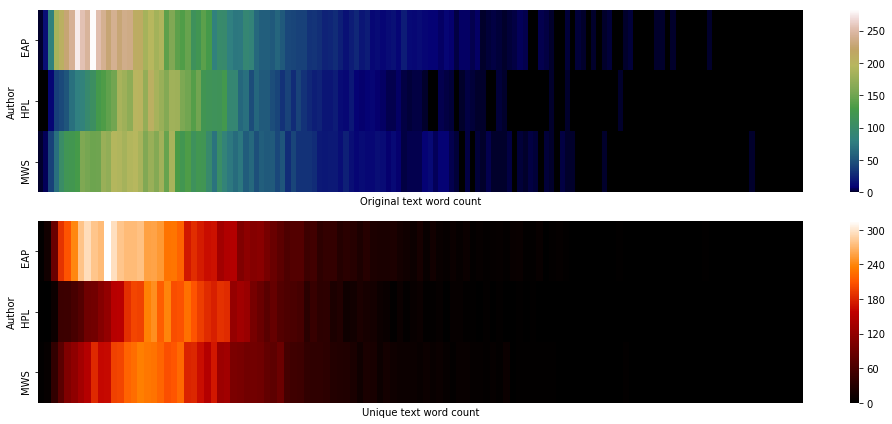

In [12]:
plt.figure(figsize=(14,6))
plt.subplot(211)
sns.heatmap(pd.crosstab(train['author'],train['num_words']),cmap='gist_earth',xticklabels=False)
plt.xlabel('Original text word count')
plt.ylabel('Author')

plt.subplot(212)
sns.heatmap(pd.crosstab(train['author'],train['num_uniq_words']),cmap='gist_heat',xticklabels=False)
plt.xlabel('Unique text word count')
plt.ylabel('Author')
plt.tight_layout()
plt.show()

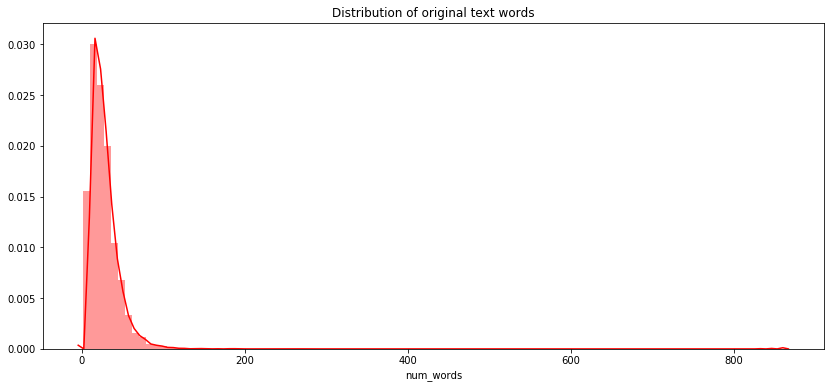

In [13]:
plt.figure(figsize=(14,6))
sns.distplot(train['num_words'],bins=100,color='r')
plt.title('Distribution of original text words')
plt.show()

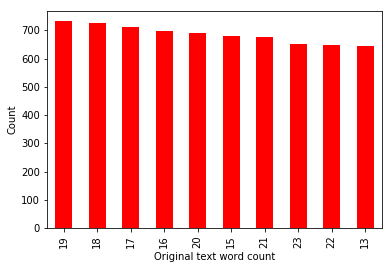

In [14]:
train['num_uniq_words'].value_counts()[0:10].plot(kind='bar',color=['r','y'])
plt.xlabel('Original text word count')
plt.ylabel('Count')
plt.show()

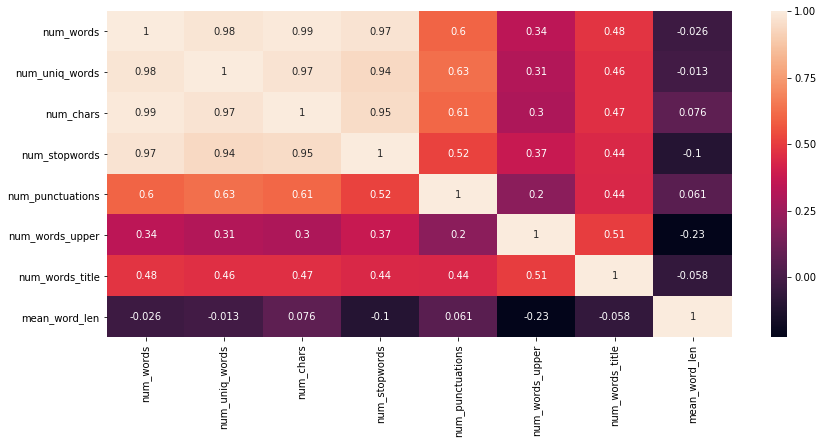

In [15]:
plt.figure(figsize=(14,6))
sns.heatmap(train.corr(),annot=True)
plt.show()

In [16]:
cv =CountVectorizer(max_features=2000,ngram_range=(1,3),dtype=np.int8,stop_words='english')
X_cv = cv.fit_transform(train['clean_text']).toarray()
X_test_cv = cv.fit_transform(test['clean_text']).toarray()

In [17]:
author_name = {'EAP':0,'HPL':1,'MWS':2}
y = train['author'].map(author_name) 

In [18]:
tfidf = TfidfVectorizer(max_features=2000,dtype=np.float32,analyzer='word',
                        ngram_range=(1, 3),use_idf=True, smooth_idf=True, 
                        sublinear_tf=True)
X_tf = tfidf.fit_transform(train['clean_text']).toarray()
X_test_tf = tfidf.fit_transform(test['clean_text']).toarray()

In [19]:
mNB = MultinomialNB()

kf = KFold(n_splits=10,shuffle=True,random_state=seed)
pred_test_full = 0
cv_score = []
i=1
for train_index,test_index in kf.split(X_tf):
    print('{} of KFlod {}'.format(i,kf.n_splits))    
    xtr,xvl = X_tf[train_index], X_tf[test_index]
    ytr,yvl = y[train_index], y[test_index]
    
    mNB.fit(xtr,ytr)
    y_mNB = mNB.predict(xvl)
    cv_score.append(log_loss(yvl,mNB.predict_proba(xvl)))    
    pred_test_full += mNB.predict_proba(X_test_tf)
    i+=1
#roc_auc_score(yvl,mNB.predict_proba(xvl)[:,1]) # not for multi class
print(cv_score)
print('Mean accuracy score',np.mean(cv_score))
print('confusion matrix:\n',confusion_matrix(yvl,y_mNB))
del xtr,ytr,xvl,yvl

1 of KFlod 10
2 of KFlod 10
3 of KFlod 10
4 of KFlod 10
5 of KFlod 10
6 of KFlod 10
7 of KFlod 10
8 of KFlod 10
9 of KFlod 10
10 of KFlod 10
[0.6429962378100883, 0.64558436917013473, 0.62894661723356615, 0.65331818533626995, 0.66290949834984436, 0.65025300581896373, 0.64577998503662248, 0.65046655809162868, 0.65250254836255761, 0.64619432149338596]
Mean accuracy score 0.64789513267
confusion matrix:
 [[649  68  91]
 [107 398  43]
 [121  41 439]]


In [20]:
unwanted = ['text','id','clean_text']
X_tf = np.concatenate((X_tf,train.drop(unwanted+['author'],axis=1).values),axis=1)
X_test_tf = np.concatenate((X_test_tf,test.drop(unwanted,axis=1).values),axis=1)

In [23]:
def runXGB(xtrain,xvalid,ytrain,yvalid,xtest,eta=0.1,early_stop=50,max_depth=5,n_rounds=1000):
    
    params = {        
        'objective':'multi:softprob',
        'learning_rate':eta,
        'max_depth':max_depth,
        'num_class':3,
        'subsample':0.8,
        'colsample_bytree':0.8,
        'eval_metric':'mlogloss',
        'min_child_weight':10,
        'reg_alpha':1.5, 
        'reg_lambda':5,
        'scale_pos_weight':1,  
        #'verbose':0,
        'seed':seed,        
        'n_thread':-1 
    }
    
    dtrain =xgb.DMatrix(xtrain,label=ytrain)
    dvalid = xgb.DMatrix(xvalid,label=yvalid)    
    dtest = xgb.DMatrix(xtest)
    watchlist = [(dtrain,'train'),(dvalid,'test')]
    
    model = xgb.train(params,dtrain,n_rounds,evals=watchlist,early_stopping_rounds=early_stop,verbose_eval=10)
    pred = model.predict(dvalid,ntree_limit = model.best_ntree_limit)
    pred_test = model.predict(dtest,ntree_limit = model.best_ntree_limit)
    
    return pred_test,model

In [27]:
kf = KFold(n_splits=5,shuffle=True,random_state=seed)
pred_test_full = 0
cv_score = []
i=1
for train_index,test_index in kf.split(X_tf):
    print('{} of KFold {}'.format(i,kf.n_splits))    
    xtr,xvl = X_tf[train_index], X_tf[test_index]
    ytr,yvl = y[train_index], y[test_index]
        
    pred_xgb,xg_model = runXGB(xtr,xvl,ytr,yvl,X_test_tf,n_rounds=200,eta=0.5)
    pred_test_full += pred_xgb
    cv_score.append(xg_model.best_score)
    i+=1


1 of KFold 5
[0]	train-mlogloss:1.04405	test-mlogloss:1.04754
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[10]	train-mlogloss:0.858056	test-mlogloss:0.887511
[20]	train-mlogloss:0.793501	test-mlogloss:0.832284
[30]	train-mlogloss:0.74316	test-mlogloss:0.79161
[40]	train-mlogloss:0.708535	test-mlogloss:0.763642
[50]	train-mlogloss:0.678459	test-mlogloss:0.741185
[60]	train-mlogloss:0.655026	test-mlogloss:0.726827
[70]	train-mlogloss:0.63592	test-mlogloss:0.711842
[80]	train-mlogloss:0.616699	test-mlogloss:0.699455
[90]	train-mlogloss:0.599648	test-mlogloss:0.69016
[100]	train-mlogloss:0.583664	test-mlogloss:0.681595
[110]	train-mlogloss:0.568791	test-mlogloss:0.675375
[120]	train-mlogloss:0.557459	test-mlogloss:0.669973
[130]	train-mlogloss:0.54566	test-mlogloss:0.665766
[140]	train-mlogloss:0.535296	test-mlogloss:0.661456
[150]	train-mlogloss:0.526251	test-mlogloss:0.656004
[160]	

In [28]:
print(cv_score)
print('Mean accuracy score',np.mean(cv_score))

[0.642676, 0.618098, 0.641399, 0.630906, 0.632064]
Mean accuracy score 0.6330286
